In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Notifications per weekday

**RQ:** How many notifications are in the notification drawer per weekday?

In [4]:
def worker_active_notifications_per_weekday(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    result = pd.DataFrame(columns=[h for h in range(0, 7)])
    d = {}
    for day in result.columns:
        d[day] = df[df.LocalTime.dt.weekday == day].Active.apply(filter_active).apply(len).mean()
    return result.append(d, ignore_index=True)

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_active_notifications_per_weekday, uuids)

weekday = pd.concat(lst)
weekday = weekday.reset_index(drop=True)
weekday.tail()

,0,1,2,3,4,5,6
3948,0.438819,0.533654,0.423423,0.885593,0.665584,1.070539,0.820000
3949,0.910256,0.636364,1.023256,0.614286,1.252874,0.845161,1.097143
3950,16.761658,17.236486,16.019512,14.595813,16.022075,18.025743,19.060391
3951,1.696154,2.437736,1.996154,1.269388,2.079245,2.160920,2.984375
3952,0.953488,0.295699,0.851351,0.600000,0.397790,1.235955,0.625000


In [6]:
weekday.describe()

,0,1,2,3,4,5,6
count,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000
mean,3.357783,3.387484,3.390015,3.453283,3.484108,3.406732,3.315730
std,4.716509,4.624591,4.746775,5.036763,5.113892,4.782215,4.590875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.184783,1.173333,1.199387,1.205240,1.237113,1.200000,1.151862
50%,2.110124,2.154135,2.104478,2.161290,2.184080,2.131234,2.079365
75%,3.609375,3.724734,3.725067,3.787234,3.841860,3.812057,3.663551
max,59.034483,61.308696,67.847328,103.000000,127.283688,75.337209,61.623037


In [7]:
weekday.mean()

0    3.357783
1    3.387484
2    3.390015
3    3.453283
4    3.484108
5    3.406732
6    3.315730
dtype: float64

In [8]:
weekday.mean().sort_values()

6    3.315730
0    3.357783
1    3.387484
2    3.390015
5    3.406732
3    3.453283
4    3.484108
dtype: float64

In [9]:
print('Notifications per weekday:')
print('M  = %s' % np.round(weekday.mean().mean(), 2))
print('SD = %s' % np.round(weekday.std().mean(), 2))
print('Md = %s' % np.round(weekday.median().mean(), 2))

Notifications per weekday:
M  = 3.4
SD = 4.8
Md = 2.13


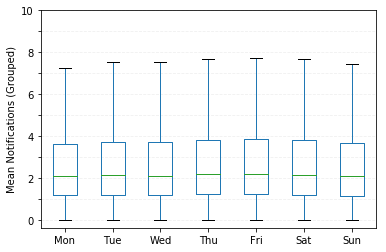

In [10]:
ax = weekday.fillna(0).boxplot(
    showfliers=False,
    figsize=(6, 4)
)

# Ticks
ax.set_yticks(range(0, 11, 1))
ax.set_yticklabels([x if x % 2 == 0 else '' for x in range(0, 11, 1)])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.0, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
#ax.set_xlabel('Mean', fontsize=10)
ax.set_ylabel('Mean Notifications (Grouped)', fontsize=10)
ax.tick_params(labelsize=10)

plt.savefig('figures/mean_active_boxplot_weekdays.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/mean_active_boxplot_weekdays.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

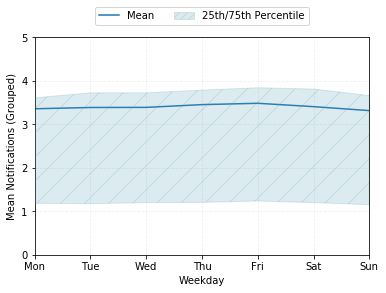

In [11]:
ax = weekday.fillna(0).mean(axis=0).plot(
    kind='line',
    xlim=(0, 6),
    xticks=range(0, 7, 1),
    yticks=range(0, 7, 1),
    ylim=(0, 5),
    figsize=(6, 4),
    legend=True,
    grid=True)

# Ticks
ax.set_xticks(range(0, 7, 1))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_yticks(range(0, 6, 1))

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Weekday', fontsize=10)
ax.set_ylabel('Mean Notifications (Grouped)', fontsize=10)
ax.tick_params(labelsize=10)

# Quantiles
ax.fill_between(range(0, 7),
                [weekday.fillna(0)[x].quantile(.25) for x in weekday.fillna(0).columns],
                [weekday.fillna(0)[x].quantile(.75) for x in weekday.fillna(0).columns],
                color='#539caf',
                alpha=0.2,
                zorder=100,
                hatch='/')

# Std
# ax.fill_between(range(0, 24),
#                 [weekday.fillna(0)[x].mean() - weekday.fillna(0)[x].std() for x in weekday.fillna(0).columns],
#                 [weekday.fillna(0)[x].mean() + weekday.fillna(0)[x].std() for x in weekday.fillna(0).columns],
#                 color='#539caf',
#                 alpha=0.2)

# Overall mean
#ax.axhline(weekday.mean().mean(), color='r', linestyle='--')

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles+[patches.Patch(color='#539caf', hatch='///', alpha=0.2)],
          labels=['Mean', '25th/75th Percentile'],
          loc='center',
          bbox_to_anchor=(0.5, 1.1),
          ncol=3, 
          prop={'size': 10})

plt.savefig('figures/mean_notifications_per_weekday.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/mean_notifications_per_weekday.pdf', bbox_inches='tight', pad_inches=0)

plt.show()